# Capstone Project - New York Community Districts
### Applied Data Science Capstone by IBM/Coursera

# 1. Introduction

The project will aim to compare the "livability" of 55 New York Community Districts based on various socio-economic parameters. This will include various factors like restaurants and night life ('social life parameters'), proximity of schools, colleges and stores ('basic needs'), crime rates and medical facilities ('hygiene'), commute times and incomes ('employment'). Finally, Community Districts will also be compared on other social parameters like racial composition and education profiles.

The comparison is being done at community district level because of 3 main reasons (a)Census data is available with low error margins at this aggregation level (b)The problem of missing data is minimized (c)State/Government interventions are done at Community District level through the various Community District boards

## 2. Data

Data will be sourced from 3 major sources:

1. **Venue data from Foursquare**: Data on restaurants, night life spots, schools, colleges, stores, medical facilities. To increase the number of results in neighborhood search, the search will be done with specific category IDs detailed at https://developer.foursquare.com/docs/build-with-foursquare/categories/  

2. **Crime data**: Historical crime data by precinct is made available by NYPD on the website https://www1.nyc.gov/site/nypd/stats/crime-statistics/historical.page .

3. **Socio-economic data**: Data on income, racial composition, education, poverty, commute times etc will be obtained from the various editions of the American Community Survey (ACS). Data is downloaded from the census website at https://data.census.gov/cedsci/

In addition to the above, geojson map data for community districts will be obtained from https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page 

Since the data is available for different geographical aggregation levels for each type of data, a mapping will be needed among these various geographical levels. Hence, precinct->neighborhood->PUMA ->community district relationships shall need to be obtained. Additionally, naming conventions of same area differ in the various datasets so an equivalence mapping will have to be used. In cases where an exhaustive listing cannot be obtained, the website https://boundaries.beta.nyc/ shall be used which lists different administrative demarcations in map form.

## 3. Gathering and cleaning data

This section will obtain and process all data required and make it ready for data anlysis. Since a large number of data points and sources are involved, some of the processing is done separately and results are pulled through an excel or csv file into this project. Wherever this is done, comments have been put to detail out the processing steps. Since the project is built iteratively, to avoid any internet errors, all files are first downloaded into a local directory and then imported into the project. Links to original sources are given at all places.

### 3.1 Gathering venue data from Foursquare

The list of category codes used is as follows:

|#| Category| Code|
|:-|:-|:-|
1| Food | 4d4b7105d754a06374d81259 |
2|College and Education | 4d4b7105d754a06372d81259 |
3| Shop and service | 4d4b7105d754a06378d81259 |
4| School | 4bf58dd8d48988d13b941735 |
5| Nightlife spot | 4d4b7105d754a06376d81259 |
6| Medical Centre | 4bf58dd8d48988d104941735 |

In [169]:
#Importing necessary libraries

import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import requests
from pandas.io.json import json_normalize

from shapely.geometry import Polygon, MultiPolygon, asShape, shape
from shapely.ops import unary_union, cascaded_union
from geojson import Feature
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature
import geojson
import folium
from folium import plugins

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
#import data on neighborhoods (the data is from the Week3 assignment)

with open('newyork_data.txt') as json_data:
    newyork_data = json.load(json_data)
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods_data = newyork_data['features']
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


While working with foursquare API, two errors were observed: 

(a)The data was fetched in two lots of 100 venues each. Sometimes the second lot of data was empty as the number of venues around the neighborhood was less than 100. In these cases, a try/except statement was able to deal with the problem

(b)In some cases, data was returned but there was an issue with the internal structure and hence the parsing was not successul. To deal with these cases, a "default" request is being created with NA values to stop the program from throwing an error.

In [4]:
defaultRes=[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': 'NA',
   'name': 'NA',
   'location': {'address': 'NA',
    'crossStreet': 'NA',
    'lat': 40.72355,
    'lng': -73.94214,
    'labeledLatLngs': [{'label': 'display',
      'lat': 40.72355,
      'lng': -73.94214}],
    'distance': 977,
    'postalCode': '11222',
    'cc': 'US',
    'city': 'Brooklyn',
    'state': 'NY',
    'country': 'United States',
    'formattedAddress': ['124 Monitor St (Driggs)',
     'Brooklyn, NY 11222',
     'United States']},
   'categories': [{'id': '4bf58dd8d48988d198941735',
     'name': 'College Academic Building',
     'pluralName': 'College Academic Buildings',
     'shortName': 'Academic Building',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/education/academicbuilding_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-57d2efd4498e6c311b52112e-0'}]

In [8]:
#Defining the function to get the data from foursquare

CLIENT_ID = '1JVUIYFHZVXRJWGD431AVQDJX3BEHUYA4EEWRNSL1XRQM5UD' 
CLIENT_SECRET = 'TDUTHYV3UBORYSHCQJ4DH045FSLMRXYJ1F3HUDEDWSUV2SGP' 
VERSION = '20200809'
AUTH_TOKEN ='FBROAYY2MLVHTTHOPBBQBLZGJIJ3D4THHY4UDH0IIQNDL31F'
CATEGORY_ID = '4bf58dd8d48988d104941735' #ID for medical centers
venue_list=[]

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit=100&categoryId={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, CATEGORY_ID)
            
            
        # make the GET request
        try:
            results1 = requests.get(url1).json()["response"]['groups'][0]['items']
        except:
            results1 = defaultRes
        
#        url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit=100&offset=100&categoryId={}'.format(
#           CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, CATEGORY_ID)
        
#        try:
#            results2 = requests.get(url2).json()["response"]['groups'][0]['items']
#        except:
#            results2 = defaultRes
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
                             v['venue']['location']['lng'],  v['venue']['categories'][0]['name']) for v in results1])
        
#        venues_list.append([(name, lat, lng, v['venue']['id'], v['venue']['name'], v['venue']['location']['lat'], 
#                             v['venue']['location']['lng'],  v['venue']['categories'][0]['name']) for v in results2])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue ID',
                             'Venue Name','Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [9]:
#Getting all medical centers around the neighborhood lat/long combinations

ny_stores = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [10]:
#Since the same centre can be around multiple neighborhoods, there will be a number of duplicates

print ('The total number of venues is {} and number of unique venues is {}'.format 
       (len(ny_stores['Venue ID']), len(ny_stores['Venue ID'].unique())))

The total number of venues is 30303 and number of unique venues is 5128


In [11]:
#Saving the long list of stores before removing the duplicates. 
#This list will be used later to classify stores that cannot be put in a Community District on the map

ny_stores.to_excel('LongListMedical.xlsx')

ny_stores.sort_values("Venue ID", inplace=True)
ny_stores.drop_duplicates(subset='Venue ID', keep = 'first', inplace = True)

ny_stores.shape

(5128, 8)

The geojson file containing the boundaries of community districts has been downloaded from the link https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts_Water_Included/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson on the website https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page 

Two versions of the map are availble: (a)Clipped to the shoreline (b)Water areas included.

The program tries to find the Community District for each venue. Hence, option (b) is used as it has a 'coarser' boundary and hence is computationally less intensive when trying each community district boundary to check if the venue lies within it

In [93]:
dfresults=[]

with open("CommDistLarger.json") as f:
    gj = geojson.load(f)

In [16]:
#The following code takes a venue and tries to assign it to a community district
#If no community district is found, a 0 is returned

for j in range (0,ny_stores['Venue Latitude'].count()):
    point = Feature(geometry=Point((ny_stores.iloc[j]['Venue Longitude'], ny_stores.iloc[j]['Venue Latitude'])))
    index = 0
    i = 0
    while index == 0 :
        polygon = Polygon(gj['features'][i].geometry.coordinates)
        if(boolean_point_in_polygon(point, polygon) ==True):
            index = 1
            dfresults.append (gj['features'][i]['properties']['BoroCD'])
        if i != 70:
            i = i +1
        if i == 70 and index == 0:
            dfresults.append (0)
            index = 1

In [17]:
#writing back the results to the dataframe

ny_stores['CommDist']=dfresults

In [18]:
ny_stores.head(3)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category,CommDist
4901,Greenpoint,40.730201,-73.954241,3fd66200f964a52010e31ee3,Dr. Kessler & Dr. Sobran,40.716615,-73.957064,Medical Center,301
11970,Soho,40.722184,-74.000657,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,0
10956,Lincoln Square,40.773529,-73.985338,49f1c450f964a520b6691fe3,Mount Sinai West,40.769502,-73.986412,Hospital,104


In [19]:
#the commercial district has been mapped under the column CommDist
#we need to now find number of '0's as these will be venues for which CommDist could not be found in the map data

sum(ny_stores['CommDist']==0)

782

Out of 5128 venues, commercial district could not be found for 782 venues. This needs to be improved. This is done separately using a neighborhood to community district mapping. From the long list obtained earlier, each venue is mapped against multiple neighborhoods. If all neighborhoods associated with a venue fall within the same community district, then the venue can be taken to fall with that particular community. This is used to improve the results.

In [20]:
ny_stores.to_excel('MedicalLongList1.xlsx')

In [2]:
ny_medical = pd.read_excel('MedicalLongList1.xlsx', sheet_name='Final')

In [3]:
ny_medical.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category,CommDist,CD
0,4901,Greenpoint,40.730201,-73.954241,3fd66200f964a52010e31ee3,Dr. Kessler & Dr. Sobran,40.716615,-73.957064,Medical Center,301,BROO01
1,11970,Soho,40.722184,-74.000657,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,0,MANH01_02
2,10956,Lincoln Square,40.773529,-73.985338,49f1c450f964a520b6691fe3,Mount Sinai West,40.769502,-73.986412,Hospital,104,MANH04_05
3,27609,Fulton Ferry,40.703281,-73.995508,4a0c62cbf964a52029751fe3,Vinegar Hill Vet,40.702468,-73.991829,Doctor's Office,302,BROO02
4,27184,Tudor City,40.746917,-73.971219,4a36c1b9f964a520dd9d1fe3,NYU Langone Medical Center,40.741822,-73.974185,Hospital,106,MANH06


In [4]:
print ("Out of a total of", ny_medical['CD'].count(), "values, the number of zeroes is", sum(ny_medical['CD']==0))

Out of a total of 5128 values, the number of zeroes is 380


In [5]:
# removing rows with values of CD as 0

ny_medical = ny_medical[ny_medical['CD']!=0]

In [6]:
ny_medical.shape

(4748, 11)

We now have 4748 venues spread across 55 community districts. The processing has also coded the community districts into a more recognizable format. The five boroughs of Brooklyn, Bronx, Manhattan, Queens and Staten Island are coded as **BROO, BRON, MANH, QUEE AND STAT** followed by the number of the community district. Census data combines 4 sets of community districts:

1. MANH01 and MANH02
2. MANH04 and MANH05
3. BRON01 and BRON02
4. BRON03 and BRON06

These pairs will be represented as MANH01_02 etc. Data from various sources will be encoded in the same manner.

In [7]:
df_final = ny_medical.groupby('CD').agg(np.size)

In [8]:
df_final.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category,CommDist
CD,,,,,,,,,,
BRON01_02,52,52,52.0,52.0,52,52,52.0,52.0,52,52
BRON03_06,47,47,47.0,47.0,47,47,47.0,47.0,47,47
BRON04,27,27,27.0,27.0,27,27,27.0,27.0,27,27
BRON05,30,30,30.0,30.0,30,30,30.0,30.0,30,30
BRON07,51,51,51.0,51.0,51,51,51.0,51.0,51,51


In [9]:
df_final.drop(columns=['Unnamed: 0','Neighborhood Latitude','Neighborhood Longitude','Venue ID','Venue Name', 
                       'Venue Latitude','Venue Longitude','Venue Category','CommDist'],inplace = True)

In [12]:
df_final.head(3)

,Medical
CD,
BRON01_02,52
BRON03_06,47
BRON04,27


In [11]:
df_final.rename(columns = {'Neighborhood':'Medical'}, inplace = True) 

In [13]:
df_final.head(3)

,Medical
CD,
BRON01_02,52
BRON03_06,47
BRON04,27


Similar working is done for restaurants, night lift spots, schools, colleges and stores. The preprocessing has been completed externally and only the final files will be imported to add more columns to df_final

In [14]:
ny_restaurants = pd.read_excel('FoodLongList.xlsx', sheet_name='Final')
ny_restaurants = ny_restaurants[ny_restaurants['CD']!=0]
df_temp = ny_restaurants.groupby('CD').agg(np.size)
df_final['Restaurants']=df_temp['Neighborhood']

In [15]:
ny_stores = pd.read_excel('StoresLongList.xlsx', sheet_name='Final')
ny_stores = ny_stores[ny_stores['CD']!=0]
df_temp = ny_stores.groupby('CD').agg(np.size)
df_final['Stores']=df_temp['Neighborhood']

In [16]:
ny_college = pd.read_excel('EducLongList.xlsx', sheet_name='Final')
ny_college = ny_college[ny_college['CD']!=0]
df_temp = ny_college.groupby('CD').agg(np.size)
df_final['Colleges']=df_temp['Neighborhood']

In [17]:
ny_schools = pd.read_excel('SchoolLongList.xlsx', sheet_name='Final')
ny_schools = ny_schools[ny_schools['CD']!=0]
df_temp = ny_schools.groupby('CD').agg(np.size)
df_final['Schools']=df_temp['Neighborhood']

In [18]:
ny_night = pd.read_excel('NightLongList.xlsx', sheet_name='Final')
ny_night = ny_night[ny_night['CD']!=0]
df_temp = ny_night.groupby('CD').agg(np.size)
df_final['Nightlife']=df_temp['Neighborhood']

In [75]:
df_final

,Medical,Restaurants,Stores,Colleges,Schools,Nightlife
CD,,,,,,
BRON01_02,52,174,257,33.0,71.0,30.0
BRON03_06,47,169,139,83.0,73.0,22.0
BRON04,27,136,163,11.0,43.0,39.0
BRON05,30,95,131,36.0,37.0,4.0
BRON07,51,157,133,39.0,40.0,10.0
BRON08,83,191,225,43.0,65.0,27.0
BRON09,22,145,165,15.0,47.0,16.0
BRON10,44,231,227,38.0,45.0,38.0
BRON11,81,190,180,31.0,39.0,8.0


#### The tabulation of venues by type in each community district is now complete

### 3.2 Gathering Crime Data

Crime data is downloaded from https://www1.nyc.gov/site/nypd/stats/crime-statistics/historical.page . Data is available in four categories (a)Seven major felony offences (b)Non-seven major felony offences (c)Misdemeanour offences (d)Violations. Only the seven major felony offences data is used for the present analysis.

The data is available at precinct level. Mapping of precincts to community district was obtained from 
https://www.researchgate.net/figure/An-Approximate-Mapping-of-NYPD-Precincts-to-NYC-Community-Districts_tbl1_247923137 . The missing data was filled with lookups from https://boundaries.beta.nyc/

In [19]:
ny_crime = pd.read_excel ('NY Collated Data.xlsx', sheet_name='CRIME_FINAL')
ny_crime.set_index("ID", inplace= True)

In [20]:
ny_crime.head()

,YEAR,MURDER,RAPE,ROBBERY,ASSAULT,BURGLARY,LARCENY,LARCENY_MOTVEH,TOTAL
ID,,,,,,,,,
BRON01_02,2010,19,43,727,834,410,704,206,2943
BRON01_02,2011,26,41,695,884,442,697,224,3009
BRON01_02,2012,20,38,809,948,363,803,135,3116
BRON01_02,2013,10,42,782,1243,415,989,181,3662
BRON01_02,2014,11,47,659,822,350,866,182,2937


The data is tabulated by community district and year and gives the number of cases for murder, rape, robbery, assault, burglary, grand larceny and larceny of motor vehicles.

In [21]:
df_temp = ny_crime[ny_crime['YEAR']==2019] #original data is for 2010-2019, we need only the latest

In [22]:
df_final['Crime']=df_temp['TOTAL']

In [23]:
df_final.head(3)

,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime
CD,,,,,,,
BRON01_02,52,174,257,33.0,71.0,30.0,3272
BRON03_06,47,169,139,83.0,73.0,22.0,2911
BRON04,27,136,163,11.0,43.0,39.0,2286


### 3.3 Gathering census data

All census data has been obtained from 2010-2019 editions of American Community Survey and downloaded from  https://data.census.gov/cedsci/ . New York data has been selected by choosing 55 **PUMAs** (Public Use Microdata Area) which correspond to the 55 community districts for our analysis. 

Since each table of census comes with its own heading nomenclature and arrangement of data in rows and columns, the data has been cleaned separately and combined in a single file 'NY Collated Data.xlsx'. Data for analysis will be pulled from this file.

In [24]:
ny_income = pd.read_excel ('NY Collated Data.xlsx', sheet_name='INCOME_FINAL')
ny_income.set_index('ID', inplace = True)

In [25]:
ny_income.head()

,YEAR,0K_10K,10K_15K,15K_25K,25K_35K,35K_50K,50K_75K,75K_100K,100K_150K,150K_200K,200K_ABOVE,MEDIAN_INC,MEAN_INC
ID,,,,,,,,,,,,,
BRON01_02,2010,23.176823,14.085914,19.380619,11.788212,11.588412,12.087912,3.196803,3.296703,0.699301,0.699301,20844,32787
BRON01_02,2011,25.374625,11.588412,19.280719,12.587413,13.386613,12.287712,3.296703,1.498501,0.499500,0.199800,21146,30356
BRON01_02,2012,27.700000,13.000000,17.500000,12.500000,11.700000,10.600000,2.500000,3.800000,0.500000,0.200000,19122,29473
BRON01_02,2013,22.444890,13.326653,16.833667,12.925852,12.825651,13.226453,3.907816,3.607214,0.300601,0.601202,23083,32992
BRON01_02,2014,25.574426,13.186813,18.381618,10.889111,14.785215,8.691309,4.395604,2.797203,0.799201,0.499500,21116,32083


The data presents the % of population in each income bracket by year and community district. Median and mean incomes are also given.

In [26]:
ny_race = pd.read_excel ('NY Collated Data.xlsx', sheet_name='RACE_FINAL')
ny_race.set_index('ID', inplace = True)

In [28]:
ny_race.head(3)

,YEAR,POP,WHITE,AFRICAN_AMERICAN,NATIVE_INDIAN,ASIAN,HAWAIIAN,OTHERS,MIXED
ID,,,,,,,,,
BRON01_02,2010,156790,24.112507,39.009503,0.731552,1.079788,0.000000,31.359781,3.706869
BRON01_02,2011,152042,22.201102,36.272214,0.516305,0.505124,0.053275,38.338091,2.113890
BRON01_02,2012,158351,18.362372,30.885185,0.457844,1.266806,0.028418,46.119065,2.880310


The data presents the % of population for each race type by year and community district. The total population in this data will be used to assess per capita metrics for various data aspects. Hence, it should be taken into the *df_final* dataframe

In [29]:
df_temp = ny_race[ny_race['YEAR']==2019]
df_final['POP']=df_temp['POP']

In [30]:
ny_educ = pd.read_excel ('NY Collated Data.xlsx', sheet_name='EDUC_FINAL')
ny_educ.set_index('ID', inplace = True)

In [32]:
ny_educ.head(3)

,YEAR,PERC_LESS_THAN_HIGH_SCHOOL,PERC_HIGH_SCHOOL,PERC_SOME_COLLEGE,PERC_GRAD_OR_HIGHER
ID,,,,,
BRON01_02,2010,42.687145,29.180340,21.172780,6.959734
BRON01_02,2011,45.594272,26.504516,20.125003,7.776208
BRON01_02,2012,43.764048,25.502599,24.079548,6.653806


The data represents educational attainment as % of population and education level. 

In [33]:
ny_commute = pd.read_excel ('NY Collated Data.xlsx', sheet_name='COMMUTE_FINAL')
ny_commute.set_index('ID', inplace = True)

In [35]:
ny_commute.head(3)

,Year,Total,Less than 5 minutes,5 to 9 minutes,10 to 14 minutes,15 to 19 minutes,20 to 24 minutes,25 to 29 minutes,30 to 34 minutes,35 to 39 minutes,40 to 44 minutes,45 to 59 minutes,60 to 89 minutes,90 or more minutes,Mean
ID,,,,,,,,,,,,,,,
BRON01_02,2010,43396,289,1216,2463,1678,3208,926,10121,885,1916,6450,10728,3516,47.263792
BRON01_02,2011,45554,744,2911,2814,2333,2689,1430,9752,1264,3484,7052,8273,2808,42.462934
BRON01_02,2012,45981,978,2154,2245,2654,4558,1302,5715,1442,3418,8828,9721,2966,44.692623


The census data does not calculate mean for the data. No distribution is also given for the '90 or more minutes' column. In the absence of these, the mean commute time is calculated as weighted average of the various columns (weights being the midpoints of ranges, and 90 for the '90 or more minutes' column).

### 3.4 Preparing geojson files for community districts

The default map downloaded earlier contains 71 community districts. However, census data etc is available only for 59 of them. The remaining are mostly empty tracts of land. Hence, the map data needs to be first reduced to 59. In the second step, the areas need to be combined for the following pairs: (MANH01, MANH02), (MANH04, MANH05), (BRON01, BRON02) and (BRON03, BRON06)

In [94]:
data = gj['features']
print ("The downloaded map contains " + str(len(gj['features'])) + " community districts" )

The downloaded map contains 71 community districts


In [95]:
list_delete = [164,226,227,228, 355, 356,480,481,482,483,484,595]

#traversing the geojson file and deleting community districts as listed in list_delete

i = 0
while i < len(gj['features']):
    if gj['features'][i]['properties']['BoroCD'] in list_delete:
        del gj['features'][i]
        i = i-1
    i = i+1

print ("The modified map contains " + str(len(gj['features'])) + " community districts" )

The modified map contains 59 community districts


In [96]:
#in all census data, 8 of the districts are listed jointly as a group
#These are (101, 102) and (104,105) in Manhattan and (201, 202) and (203,206) in Bronx
#The map boundaries need to be adjusted for this
    
polygonManh1 = asShape(gj['features'][0]['geometry'])
polygonManh2 = asShape(gj['features'][1]['geometry'])
propertiesManh1_2 = gj['features'][0]['properties']
propertiesManh1_2['BoroCD']='101_102'
polygonManh1_2 = [polygonManh1, polygonManh2]

polygonManh4 = asShape(gj['features'][3]['geometry'])
polygonManh5 = asShape(gj['features'][4]['geometry'])
propertiesManh4_5 = gj['features'][3]['properties']
propertiesManh4_5['BoroCD']='104_105'
polygonManh4_5 = [polygonManh4, polygonManh5]

polygonBron1 = asShape(gj['features'][12]['geometry'])
polygonBron2 = asShape(gj['features'][13]['geometry'])
propertiesBron1_2 = gj['features'][12]['properties']
propertiesBron1_2['BoroCD']='201_202'
polygonBron1_2 = [polygonBron1, polygonBron2]

polygonBron3 = asShape(gj['features'][14]['geometry'])
polygonBron6 = asShape(gj['features'][17]['geometry'])
propertiesBron3_6 = gj['features'][14]['properties']
propertiesBron3_6['BoroCD']='203_206'
polygonBron3_6 = [polygonBron3, polygonBron6]

In [97]:
#combining the relevant community districts to create new combined shapes

Manh1_2 = unary_union (polygonManh1_2)
featureManh1_2 = Feature(geometry=Manh1_2, properties = propertiesManh1_2)

Manh4_5 = unary_union (polygonManh4_5)
featureManh4_5 = Feature(geometry=Manh4_5, properties = propertiesManh4_5)

Bron1_2 = unary_union (polygonBron1_2)
featureBron1_2 = Feature(geometry=Bron1_2, properties = propertiesBron1_2)

Bron3_6 = unary_union (polygonBron3_6)
featureBron3_6 = Feature(geometry=Bron3_6, properties = propertiesBron3_6)

In [98]:
#deleting the original community districs as they are replaced by the new combined shape
#taking care that once a feature is deleted, the index numbering changes for all elements

del gj['features'][0]
del gj['features'][0]
del gj['features'][1]
del gj['features'][1]
del gj['features'][8]
del gj['features'][8]
del gj['features'][8]
del gj['features'][10]

In [99]:
#adding back the combined districts

gj['features'].append(featureManh1_2)
gj['features'].append(featureManh4_5)
gj['features'].append(featureBron1_2)
gj['features'].append(featureBron3_6)

In [100]:
#checking output

for i in range(0,len(gj['features'])):
    print (gj['features'][i]['properties']['BoroCD'], i+1)

103 1
106 2
107 3
108 4
109 5
110 6
111 7
112 8
204 9
205 10
207 11
208 12
209 13
210 14
211 15
212 16
301 17
302 18
303 19
304 20
305 21
306 22
307 23
308 24
309 25
310 26
311 27
312 28
313 29
314 30
315 31
316 32
317 33
318 34
401 35
402 36
403 37
404 38
405 39
406 40
407 41
408 42
409 43
410 44
411 45
412 46
413 47
414 48
501 49
502 50
503 51
101_102 52
104_105 53
201_202 54
203_206 55


In [104]:
#renaming the community district as per a standard convention for consistency between files

df_names =['MANH03','MANH06','MANH07','MANH08','MANH09','MANH10','MANH11','MANH12',
           'BRON04','BRON05','BRON07','BRON08','BRON09','BRON10','BRON11','BRON12',
            'BROO01','BROO02','BROO03','BROO04','BROO05','BROO06','BROO07','BROO08','BROO09',
          'BROO10','BROO11','BROO12','BROO13','BROO14','BROO15','BROO16','BROO17','BROO18',
          'QUEE01','QUEE02','QUEE03','QUEE04','QUEE05','QUEE06','QUEE07','QUEE08','QUEE09',
           'QUEE10','QUEE11','QUEE12','QUEE13','QUEE14','STAT01','STAT02','STAT03',
           'MANH01_02','MANH04_05','BRON01_02','BRON03_06']

for i in range(0,len(gj['features'])):
    gj['features'][i]['properties']['BoroCD']=df_names[i]

In [105]:
#checking output
for i in range(0,len(gj['features'])):
    print(gj['features'][i]['properties']['BoroCD'], i+1)

MANH03 1
MANH06 2
MANH07 3
MANH08 4
MANH09 5
MANH10 6
MANH11 7
MANH12 8
BRON04 9
BRON05 10
BRON07 11
BRON08 12
BRON09 13
BRON10 14
BRON11 15
BRON12 16
BROO01 17
BROO02 18
BROO03 19
BROO04 20
BROO05 21
BROO06 22
BROO07 23
BROO08 24
BROO09 25
BROO10 26
BROO11 27
BROO12 28
BROO13 29
BROO14 30
BROO15 31
BROO16 32
BROO17 33
BROO18 34
QUEE01 35
QUEE02 36
QUEE03 37
QUEE04 38
QUEE05 39
QUEE06 40
QUEE07 41
QUEE08 42
QUEE09 43
QUEE10 44
QUEE11 45
QUEE12 46
QUEE13 47
QUEE14 48
STAT01 49
STAT02 50
STAT03 51
MANH01_02 52
MANH04_05 53
BRON01_02 54
BRON03_06 55


In [106]:
#writing output to a new file for later use
with open('shortened_final.json', 'w') as data_file:
    data = json.dump(gj, data_file)

In [107]:
ny_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
ny_map.choropleth(geo_data='shortened_final.json')
ny_map

## Exploring the dataset

Before the community districts are compared, the number of venues in each community district needs to be standardized. It can be done either by the area of each district or the population of each district. In this project, population will be used for standardization. The number of venues and the number of crimes will be standardized.

In [54]:
df_final.head(3)

,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP
CD,,,,,,,,
BRON01_02,52,174,257,33.0,71.0,30.0,3272,146824
BRON03_06,47,169,139,83.0,73.0,22.0,2911,172930
BRON04,27,136,163,11.0,43.0,39.0,2286,140906


In [55]:
df_final['Medical']=(df_final['Medical']/df_final['POP'])*10000

In [57]:
df_final['Restaurants']=(df_final['Restaurants']/df_final['POP'])*10000
df_final['Stores']=(df_final['Stores']/df_final['POP'])*10000
df_final['Colleges']=(df_final['Colleges']/df_final['POP'])*10000
df_final['Schools']=(df_final['Schools']/df_final['POP'])*10000
df_final['Nightlife']=(df_final['Nightlife']/df_final['POP'])*10000
df_final['Crime']=(df_final['Crime']/df_final['POP'])*10000

In [66]:
df_final.head(3)

,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP
CD,,,,,,,,
BRON01_02,3.541655,11.850924,17.503950,2.247589,4.835722,2.043263,222.851850,146824
BRON03_06,2.717863,9.772740,8.037934,4.799630,4.221361,1.272191,168.334008,172930
BRON04,1.916171,9.651825,11.567996,0.780662,3.051680,2.767803,162.235817,140906


In [75]:
df_final.reset_index(inplace =True)
list(df_final.columns.values)

['CD',
 'Medical',
 'Restaurants',
 'Stores',
 'Colleges',
 'Schools',
 'Nightlife',
 'Crime',
 'POP']

In [113]:
df_restaurants = df_final[['CD','Restaurants']]
df_restaurants.head(3)

,CD,Restaurants
0,BRON01_02,11.850924
1,BRON03_06,9.772740
2,BRON04,9.651825


We can now explore each aspect on the map to see the difference visually across New York

In [114]:
ny_map1 = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
choropleth = folium.Choropleth(
    geo_data='shortened_final.json',
    data=df_restaurants,
    columns=['CD', 'Restaurants'],
    key_on='feature.properties.BoroCD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurants per 10k population in NY Community Districts'
).add_to(ny_map1)

folium.LayerControl().add_to(ny_map1)
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['BoroCD'], labels=False)
)
# display map
ny_map1

By hovering on the dark areas of the map, it is seen that MANH01_02, MANH04_05 and BROO06 have the highest concentration of restaurants

In [120]:
df_crime = df_final[['CD','Crime']]

ny_map2 = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
choropleth1 = folium.Choropleth(
    geo_data='shortened_final.json',
    data=df_crime,
    columns=['CD', 'Crime'],
    key_on='feature.properties.BoroCD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime per 10k population in NY Community Districts'
).add_to(ny_map2)

folium.LayerControl().add_to(ny_map2)
choropleth1.geojson.add_child(
    folium.features.GeoJsonTooltip(['BoroCD'], labels=False)
)
# display map
ny_map2

Crime per capita is highest in MANH04_05

In [123]:
ny_income.reset_index(inplace=True)
df_income = ny_income[['ID','MEDIAN_INC']]

In [126]:
ny_map3 = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
choropleth3 = folium.Choropleth(
    geo_data='shortened_final.json',
    data=df_income,
    columns=['ID', 'MEDIAN_INC'],
    key_on='feature.properties.BoroCD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median income in NY Community Districts'
).add_to(ny_map3)

folium.LayerControl().add_to(ny_map3)
choropleth3.geojson.add_child(
    folium.features.GeoJsonTooltip(['BoroCD'], labels=False)
)
# display map
ny_map3

In [141]:
data_stats = df_final.describe()
data_stats = data_stats.transpose()
data_stats['CoeffOfVar']=data_stats['std']/data_stats['mean']

In [144]:
data_stats

,count,mean,std,min,25%,50%,75%,max,CoeffOfVar
Medical,55.0,5.699603,3.652741,0.360776,3.248609,4.423196,7.512803,20.144659,0.640876
Restaurants,55.0,17.105829,9.204329,2.453279,10.782404,14.963579,21.013938,48.239584,0.538081
Stores,55.0,20.719581,13.536227,3.607764,12.650236,15.915327,23.526389,72.508817,0.653306
Colleges,54.0,3.744257,3.944273,0.608370,1.134090,2.165599,4.379931,18.411142,1.053419
Schools,54.0,4.505328,2.345415,1.825702,2.994440,3.900339,5.374865,15.003885,0.520587
Nightlife,54.0,4.131345,5.434274,0.233701,1.260157,2.188475,3.502780,26.480961,1.315376
Crime,55.0,114.447825,56.856912,19.087991,79.018780,104.520043,137.460594,366.310001,0.496793
POP,55.0,151578.490909,32065.564924,104149.000000,128348.000000,147401.000000,167880.500000,241275.000000,0.211544


The *coefficient of variation* helps us understand the relative distribution of various parameters. A lower CoV indicates a more uniform distribution. So, restaurants and incidence of crime seem to be more uniformly distributed across the community districs. Colleges and nightlife spots seem to be more concentrated in a few spots across the city

## Data Analysis

Before going on to clustering neighborhoods, we will try to find if the level of crime in a community district is determined by the socio-economic characterists of a community district

In [145]:
ny_crime['PerCapita']=ny_crime['TOTAL']/ny_race['POP']

In [146]:
y = ny_crime ['PerCapita']

In [163]:

ny_race.reset_index(inplace = True)
ny_educ.reset_index(inplace = True)
ny_educ.head()

,ID,YEAR,PERC_LESS_THAN_HIGH_SCHOOL,PERC_HIGH_SCHOOL,PERC_SOME_COLLEGE,PERC_GRAD_OR_HIGHER
0,BRON01_02,2010,42.687145,29.180340,21.172780,6.959734
1,BRON01_02,2011,45.594272,26.504516,20.125003,7.776208
2,BRON01_02,2012,43.764048,25.502599,24.079548,6.653806
3,BRON01_02,2013,40.770512,26.507372,23.098987,9.623129
4,BRON01_02,2014,39.823076,27.800000,24.340627,8.036297


In [164]:
#constructing the dataset to run regression

data1 = [ny_income['0K_10K'], ny_income['10K_15K'],ny_income['15K_25K'],ny_income['25K_35K'],ny_income['35K_50K'],
       ny_income['50K_75K'],ny_income['75K_100K'],ny_income['100K_150K'],ny_income['150K_200K'],ny_income['200K_ABOVE'],
       ny_race['WHITE'],ny_race['AFRICAN_AMERICAN'],ny_race['NATIVE_INDIAN'],ny_race['ASIAN'],ny_race['HAWAIIAN'],
       ny_race['OTHERS'],ny_race['MIXED'],
       ny_educ['PERC_LESS_THAN_HIGH_SCHOOL'], ny_educ['PERC_HIGH_SCHOOL'],ny_educ['PERC_SOME_COLLEGE'],
       ny_educ['PERC_GRAD_OR_HIGHER']]

headers = ["0K_10K","10K_15K" ,"15K_25K","25K_35K","35K_50K","50K_75K","75K_100K","100K_150K","150K_200K","200K_ABOVE",
          "WHITE", "AFRICAN_AMERICAN","NATIVE_INDIAN", "ASIAN","HAWAIIAN","OTHERS","MIXED",
          "PERC_LESS_THAN_HIGH_SCHOOL", "PERC_HIGH_SCHOOL","PERC_SOME_COLLEGE", "PERC_GRAD_OR_HIGHER"]
           
df3 = pd.concat(data1,  keys=headers, axis = 1)
df3



,0K_10K,10K_15K,15K_25K,25K_35K,35K_50K,50K_75K,75K_100K,100K_150K,150K_200K,200K_ABOVE,WHITE,AFRICAN_AMERICAN,NATIVE_INDIAN,ASIAN,HAWAIIAN,OTHERS,MIXED,PERC_LESS_THAN_HIGH_SCHOOL,PERC_HIGH_SCHOOL,PERC_SOME_COLLEGE,PERC_GRAD_OR_HIGHER
0,23.176823,14.085914,19.380619,11.788212,11.588412,12.087912,3.196803,3.296703,0.699301,0.699301,24.112507,39.009503,0.731552,1.079788,0.000000,31.359781,3.706869,42.687145,29.180340,21.172780,6.959734
1,25.374625,11.588412,19.280719,12.587413,13.386613,12.287712,3.296703,1.498501,0.499500,0.199800,22.201102,36.272214,0.516305,0.505124,0.053275,38.338091,2.113890,45.594272,26.504516,20.125003,7.776208
2,27.700000,13.000000,17.500000,12.500000,11.700000,10.600000,2.500000,3.800000,0.500000,0.200000,18.362372,30.885185,0.457844,1.266806,0.028418,46.119065,2.880310,43.764048,25.502599,24.079548,6.653806
3,22.444890,13.326653,16.833667,12.925852,12.825651,13.226453,3.907816,3.607214,0.300601,0.601202,9.621651,30.750253,0.365768,0.428979,0.000000,56.458928,2.374421,40.770512,26.507372,23.098987,9.623129
4,25.574426,13.186813,18.381618,10.889111,14.785215,8.691309,4.395604,2.797203,0.799201,0.499500,7.334263,35.096651,0.275207,0.895021,0.388281,54.425147,1.585431,39.823076,27.800000,24.340627,8.036297
5,24.600000,10.500000,15.700000,14.300000,13.000000,10.300000,5.200000,3.900000,1.600000,0.900000,10.688433,31.343247,0.924372,0.863797,0.000000,54.207227,1.972923,40.707042,26.002792,23.712979,9.577188
6,23.647295,10.721443,12.424850,12.625251,13.927856,10.721443,8.216433,4.709419,1.803607,1.202405,11.961725,34.500698,0.915368,0.908151,0.081794,46.819068,4.813198,35.503242,29.250036,26.678105,8.568617
7,26.400000,11.100000,17.600000,10.800000,11.300000,10.500000,6.700000,4.100000,1.000000,0.500000,20.593258,34.281804,0.406122,0.367748,0.092736,41.349604,2.908728,39.298085,27.158393,24.359716,9.183806
8,18.000000,15.100000,15.700000,12.000000,14.700000,11.400000,5.700000,5.100000,1.500000,0.800000,18.341128,34.245715,0.528649,0.712792,0.073779,42.161424,3.936513,32.139266,30.749144,25.292602,11.818988
9,21.400000,16.100000,12.500000,8.500000,12.100000,11.800000,5.100000,8.200000,2.000000,2.300000,17.869013,38.088460,0.449518,0.499918,0.000000,38.938457,4.154634,29.554564,30.288191,27.654751,12.502494


In [166]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Input=[('scale',StandardScaler()), ('model',LinearRegression())]

pipe=Pipeline(Input)
pipe

Pipeline(steps=[('scale', StandardScaler()), ('model', LinearRegression())])

In [167]:
pipe.fit (df3,y)
pipe.score (df3,y)

0.3397364408604737

As can be seen, income distribution, race and education levels are able to explain only 34% of the variance in levels of crime in various community districts

In [176]:
df_final1=df_final.drop(columns=['CD'])
df_final1.isna().sum()

Medical        0
Restaurants    0
Stores         0
Colleges       1
Schools        1
Nightlife      1
Crime          0
POP            0
dtype: int64

In [178]:

df_final1['Colleges'].fillna((df_final1['Colleges'].mean()), inplace = True)
df_final1['Schools'].fillna((df_final1['Schools'].mean()), inplace = True)
df_final1['Nightlife'].fillna((df_final1['Nightlife'].mean()), inplace = True)

C:\Users\Naween\anaconda3New\envs\playground\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


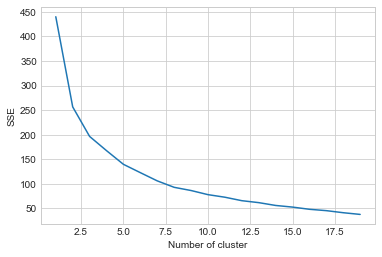

In [179]:
from sklearn.cluster import KMeans 


cluster_dataset = StandardScaler().fit_transform(df_final1)

sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(cluster_dataset)
#    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the above elbow plot, the optimum number of clsuters is seen as 6

In [187]:
num_clusters = 6

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(cluster_dataset)

labels = kmeans.labels_

print(labels)

[0 4 0 0 0 2 4 0 0 0 5 1 0 0 4 5 0 0 0 2 4 0 0 0 2 0 0 4 1 5 3 5 2 2 2 0 2
 4 5 2 4 0 4 2 4 2 0 0 2 4 4 0 2 0 2]


In [189]:
df_final.insert(len(df_final.columns),"LABELS", labels)

In [190]:
df_final.head()

,CD,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP,LABELS
0,BRON01_02,3.541655,11.850924,17.503950,2.247589,4.835722,2.043263,222.851850,146824,0
1,BRON03_06,2.717863,9.772740,8.037934,4.799630,4.221361,1.272191,168.334008,172930,4
2,BRON04,1.916171,9.651825,11.567996,0.780662,3.051680,2.767803,162.235817,140906,0
3,BRON05,2.170626,6.873648,9.478399,2.604751,2.677105,0.289417,128.573392,138209,0
4,BRON07,3.362253,10.350465,8.768229,2.571135,2.637061,0.659265,129.018222,151684,0


In [191]:
df_final.groupby('LABELS', as_index=False).mean()

,LABELS,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP
0,0,3.640295,12.102972,13.397642,1.746354,3.384953,1.813173,114.180761,135003.608696
1,1,11.472870,38.957354,58.061403,14.103552,9.297641,16.026626,168.011002,148930.000000
2,2,7.719272,19.350684,23.503295,5.856972,5.343475,3.122629,81.780369,144350.000000
3,3,20.144659,48.239584,72.508817,18.411142,15.003885,26.480961,366.310001,167290.000000
4,4,3.865478,12.493195,14.043507,1.966674,3.126360,1.648173,104.954518,194818.545455
5,5,8.758033,29.462784,36.555628,3.875564,6.272890,13.188911,149.699265,149406.000000


It is seen that the mean of different gropus vary widely and hence the clustering seems to be done correctly

In [208]:
df_clusters = df_final[['CD','LABELS']]

In [214]:
#Folium maps do not display categorical data well, so using plotly
import plotly.express as px

fig = px.choropleth_mapbox(df_clusters, geojson='shortened_final.json', color="LABELS",
                           locations="CD", featureidkey="properties.BoroCD",
                           center={"lat": 40.730610, "lon": -73.935242},
                           mapbox_style="carto-positron", zoom=9)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [215]:
df_final.head()

,CD,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP,LABELS
0,BRON01_02,3.541655,11.850924,17.503950,2.247589,4.835722,2.043263,222.851850,146824,0
1,BRON03_06,2.717863,9.772740,8.037934,4.799630,4.221361,1.272191,168.334008,172930,4
2,BRON04,1.916171,9.651825,11.567996,0.780662,3.051680,2.767803,162.235817,140906,0
3,BRON05,2.170626,6.873648,9.478399,2.604751,2.677105,0.289417,128.573392,138209,0
4,BRON07,3.362253,10.350465,8.768229,2.571135,2.637061,0.659265,129.018222,151684,0


In [253]:
#Adding commute times to the dataset

df_temp = ny_commute[ny_commute['Year']==2019]
df_temp.reset_index(inplace=True)
df_final['Commute']=df_temp['Mean']


In [254]:
df_final.head(3)

,CD,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP,LABELS,rank_medical,rank_rest,rank_stores,rank_colleges,rank_schools,rank_nightlife,rank_crime,FinalRank,FinalScore,Commute,rank_commute
0,BRON01_02,3.541655,11.850924,17.503950,2.247589,4.835722,2.043263,222.851850,146824,0,37.0,37.0,26.0,27.0,17.0,28.0,54.0,NaN,226.0,46.832286,NaN
1,BRON03_06,2.717863,9.772740,8.037934,4.799630,4.221361,1.272191,168.334008,172930,4,46.0,48.0,53.0,12.0,22.0,40.0,47.0,NaN,268.0,49.064434,NaN
2,BRON04,1.916171,9.651825,11.567996,0.780662,3.051680,2.767803,162.235817,140906,0,51.0,50.0,45.0,50.0,38.0,23.0,46.0,NaN,303.0,48.530561,NaN


In [255]:
#Ranking the Community Districts on various parameters to construct the Liveability Index

df_final['rank_medical'] = df_final['Medical'].rank(ascending = 0) 
df_final['rank_rest'] = df_final['Restaurants'].rank(ascending = 0) 
df_final['rank_stores'] = df_final['Stores'].rank(ascending = 0) 
df_final['rank_colleges'] = df_final['Colleges'].rank(ascending = 0) 
df_final['rank_schools'] = df_final['Schools'].rank(ascending = 0) 
df_final['rank_nightlife'] = df_final['Nightlife'].rank(ascending = 0)
df_final['rank_crime'] = df_final['Crime'].rank(ascending = 1) 
df_final['rank_commute']=df_final['Commute'].rank(ascending =1)

In [256]:
df_final.head()

,CD,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP,LABELS,rank_medical,rank_rest,rank_stores,rank_colleges,rank_schools,rank_nightlife,rank_crime,FinalRank,FinalScore,Commute,rank_commute
0,BRON01_02,3.541655,11.850924,17.503950,2.247589,4.835722,2.043263,222.851850,146824,0,37.0,37.0,26.0,27.0,17.0,28.0,54.0,NaN,226.0,46.832286,22.0
1,BRON03_06,2.717863,9.772740,8.037934,4.799630,4.221361,1.272191,168.334008,172930,4,46.0,48.0,53.0,12.0,22.0,40.0,47.0,NaN,268.0,49.064434,34.0
2,BRON04,1.916171,9.651825,11.567996,0.780662,3.051680,2.767803,162.235817,140906,0,51.0,50.0,45.0,50.0,38.0,23.0,46.0,NaN,303.0,48.530561,33.0
3,BRON05,2.170626,6.873648,9.478399,2.604751,2.677105,0.289417,128.573392,138209,0,50.0,53.0,50.0,22.0,46.0,53.0,39.0,NaN,313.0,52.182791,53.0
4,BRON07,3.362253,10.350465,8.768229,2.571135,2.637061,0.659265,129.018222,151684,0,41.0,45.0,52.0,23.0,48.0,51.0,40.0,NaN,300.0,52.154145,52.0


In [257]:
df_final['FinalScore'] = df_final['rank_medical']+df_final['rank_rest']+df_final['rank_stores']+ df_final['rank_colleges']+df_final['rank_schools']+df_final['rank_nightlife']+df_final['rank_crime']+df_final['rank_commute']

In [258]:
df_final.head(3)

,CD,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP,LABELS,rank_medical,rank_rest,rank_stores,rank_colleges,rank_schools,rank_nightlife,rank_crime,FinalRank,FinalScore,Commute,rank_commute
0,BRON01_02,3.541655,11.850924,17.503950,2.247589,4.835722,2.043263,222.851850,146824,0,37.0,37.0,26.0,27.0,17.0,28.0,54.0,NaN,248.0,46.832286,22.0
1,BRON03_06,2.717863,9.772740,8.037934,4.799630,4.221361,1.272191,168.334008,172930,4,46.0,48.0,53.0,12.0,22.0,40.0,47.0,NaN,302.0,49.064434,34.0
2,BRON04,1.916171,9.651825,11.567996,0.780662,3.051680,2.767803,162.235817,140906,0,51.0,50.0,45.0,50.0,38.0,23.0,46.0,NaN,336.0,48.530561,33.0


In [259]:
df_final['FinalRank'] = df_final['FinalScore'].rank(ascending = 0) 

In [260]:
#Sorting Community Districts as per the Liveability Index

df_ranked = df_final[['CD','FinalRank']]
df_ranked.sort_values('FinalRank')

,CD,FinalRank
25,BROO16,1.0
14,BROO05,2.0
6,BRON09,3.0
3,BRON05,4.0
4,BRON07,5.0
49,QUEE12,6.0
2,BRON04,7.0
27,BROO18,8.0
26,BROO17,9.5
47,QUEE10,9.5


This concludes our ranking of community districts in New York in order of livability determined by concentration of restaurants/stores/night life, schools/colleges, medical facilities, time taken for commute and incidence of crime.

## Results and discussion

The analysis achieved two objectives (a)Clustering New York community districts based on socio-economic characteristics (b)Ranking of community districts based on livability characteristics

For a person newly moving into New York, the ranking on livability can be used. However, for a person moving within the city, he/she would like to consider the next location based on similarity on socio-economic characteristics.

The analysis can be further improved by adding weights to the different characteristics based on personal preferences. 

In [261]:
df_final

,CD,Medical,Restaurants,Stores,Colleges,Schools,Nightlife,Crime,POP,LABELS,rank_medical,rank_rest,rank_stores,rank_colleges,rank_schools,rank_nightlife,rank_crime,FinalRank,FinalScore,Commute,rank_commute
0,BRON01_02,3.541655,11.850924,17.503950,2.247589,4.835722,2.043263,222.851850,146824,0,37.0,37.0,26.0,27.0,17.0,28.0,54.0,23.0,248.0,46.832286,22.0
1,BRON03_06,2.717863,9.772740,8.037934,4.799630,4.221361,1.272191,168.334008,172930,4,46.0,48.0,53.0,12.0,22.0,40.0,47.0,13.0,302.0,49.064434,34.0
2,BRON04,1.916171,9.651825,11.567996,0.780662,3.051680,2.767803,162.235817,140906,0,51.0,50.0,45.0,50.0,38.0,23.0,46.0,7.0,336.0,48.530561,33.0
3,BRON05,2.170626,6.873648,9.478399,2.604751,2.677105,0.289417,128.573392,138209,0,50.0,53.0,50.0,22.0,46.0,53.0,39.0,4.0,366.0,52.182791,53.0
4,BRON07,3.362253,10.350465,8.768229,2.571135,2.637061,0.659265,129.018222,151684,0,41.0,45.0,52.0,23.0,48.0,51.0,40.0,5.0,352.0,52.154145,52.0
5,BRON08,7.969352,18.339110,21.603664,4.128700,6.241058,2.592440,92.079617,104149,2,12.0,18.0,17.0,16.0,11.0,24.0,21.0,39.5,151.0,48.372843,32.0
6,BRON09,1.233606,8.130583,9.252042,0.841095,2.635430,0.897168,104.520043,178339,4,53.0,52.0,51.0,47.0,49.0,43.0,28.0,3.0,374.0,52.063185,51.0
7,BRON10,3.968147,20.832770,20.472029,3.427036,4.058332,3.427036,105.967551,110883,0,32.0,15.0,21.0,21.0,25.0,15.0,30.0,34.0,183.0,46.966459,24.0
8,BRON11,6.471975,15.181175,14.382166,2.476929,3.116136,0.639207,92.285566,125155,0,21.0,26.0,33.0,25.0,37.0,52.0,22.0,20.0,253.0,49.430348,37.0
9,BRON12,2.682260,15.020653,15.355936,2.011695,4.090446,1.810525,136.594067,149128,0,47.0,27.0,31.0,30.0,24.0,32.0,41.0,18.0,271.0,49.710810,39.0
